# Baseline Models

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F

from constants.date_time import DatetimeFreq
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from models.hawkes_model import HawkesModelGeneral, IndHawkesModel
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup


from utils.plots import DistributionPlotter
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
import pickle
from utils.utils import pshape, pmax, pmin, pmean, get_data_sub_paths, by_ref
import os

%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models,\
                                get_models_metrics, get_models_results, get_metrics_table, get_all_metrics
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage

In [2]:
data_sub_paths = get_data_sub_paths()
print(np.sort(data_sub_paths))

['T168H-X1275M-Y1320M_2001-01-04_2019-01-03_#1f1'
 'T1H-X2550M-Y2640M_2014-01-01_2019-01-01_#7ce'
 'T24H-X1275M-Y1320M_2012-01-01_2019-01-01_#939'
 'T24H-X1700M-Y1760M_2014-01-01_2019-01-01_#828'
 'T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97'
 'T24H-X425M-Y440M_2012-01-01_2019-01-01_#827'
 'T24H-X850M-Y880M_2012-01-01_2019-01-01_#826'
 'Totals_T168H_2001-01-04_2019-01-10_LAT41.641_42.024_LON-87.821_-87.525'
 'Totals_T1H_2014-01-01_2019-01-01_LAT41.641_42.024_LON-87.821_-87.525'
 'Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525']


In [3]:
# data_sub_paths = by_ref("827")
# print(f"using: {data_sub_paths}")

#### Independent Hawkes Models (each cell has it's own Hawkes model estimation)

In [4]:
# run HAWKES INDEPENDENT MODEL for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()

    conf.use_classification = False
    
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------ HAWKES INDEPENDENT MODEL
    conf.model_name = f"Ind-Hawkes Model"  # tod add the actual parameters as well
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets
    trn_y_class = np.copy(trn_y_true)
    trn_y_class[trn_y_class > 0] = 1

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_y_count = data_group.to_counts(tst_y_true)
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for
    freqstr = DatetimeFreq.convert(data_group.t_range)
    time_step = 24 / int(freqstr[:freqstr.find("H")])

    kernel_size = int(time_step*30)  # 30 days worth of previous steps

    N,L = np.shape(trn_crimes)

    model = IndHawkesModel(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_class=trn_y_class,
                            y_score=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_count = tst_y_count[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_count=tst_y_count,
                 y_pred=tst_y_pred,
                 y_score=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)
    
    # ------------HAWKES INDEPENDENT MODEL    

2020-12-08T10:13:05 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97
2020-12-08T10:13:05 | root | INFO | Initialising Flat Data Group
2020-12-08T10:13:05 | root | INFO | loading crimes grids WITHOUT crime types
2020-12-08T10:13:05 | root | INFO | 	t_range: (2558,) 2012-01-01 00:00:00 -> 2019-01-01 00:00:00
2020-12-08T10:13:05 | root | INFO | 	target_len:	2191	(100.000%)
2020-12-08T10:13:05 | root | INFO | 	trn_val_size:	1831	(83.569%)
2020-12-08T10:13:05 | root | INFO | 	trn_size:	1374	(62.711%)
2020-12-08T10:13:05 | root | INFO | 	val_size:	457	(20.858%)
2020-12-08T10:13:05 | root | INFO | 	tst_size:	360 	(16.431%)
2020-12-08T10:13:05 | root | INFO | =====================================BEGIN=====================================
2020-12-08T10:13:07 | root | INFO | f1_score: 0.44508644562532745 at index 138485, new threshold 0.16355200408361295
2020-12-08T10:13:09 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Cla

/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2020-12-08T10:13:21 | root | INFO | =====================================BEGIN=====================================
2020-12-08T10:13:39 | root | INFO | f1_score: 0.8061401146462509 at index 52624, new threshold 0.29977963222343834
2020-12-08T10:13:40 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:0.695
                Model Name: Ind-Hawkes Model
                    NDCG:               0.89238                
                    ROC AUC:            0.79140                
                    Average Precision:  0.83788
                    Precision:          0.69491
                    Recall:             0.91880
                    Accuracy:           0.71407
                    MCC:                0.40162
                    PAI:                1.22380
                    MAE:                1.09704
                    RMSE:               1.85494      
            
2020-12-08T10:13:40 | root | INFO | 
CALCULATING BASE LINE

FileNotFoundError: [Errno 2] No such file or directory: './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/generated_data.npz'

#### General Hawkes Model (each cell uses the same Hawkes model)

In [ ]:
# # run HAWKES GENERAL MODEL for all data dimensions
# for data_sub_path in data_sub_paths:
#     conf = BaseConf()
    
#     conf.data_path = f"./data/processed/{data_sub_path}/"
#     setup_logging(save_dir=conf.data_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
    
#     log.info("\n===================================================="+\
#              "===============================================================\n" + \
#              f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
#             "=============================================================="+\
#              "=====================================================")

#     if not os.path.exists(conf.data_path):
#         raise Exception(f"Directory ({conf.data_path}) needs to exist.")

#     # LOAD DATA
#     data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
#     loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
#     # ------------ HAWKES GENERAL MODEL
#     conf.model_name = f"Hawkes General Model"  # tod add the actual parameters as well
#     conf.model_path = conf.data_path + f"models/{conf.model_name}/"
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
    
#     log.info("=====================================BEGIN=====================================")
#     test_set_size = data_group.testing_set.target_shape[0]

#     trn_crimes = data_group.training_set.crimes[:,0]
#     trn_y_true = data_group.training_set.targets
#     trn_y_class = data_group.training_set.labels

#     tst_crimes = data_group.testing_set.crimes[:,0]
#     tst_y_true = data_group.testing_set.targets
#     tst_y_count = data_group.to_counts(tst_y_true)
#     tst_t_range = data_group.testing_set.t_range

#     # time step in this context is used for
#     freqstr = DatetimeFreq.convert(data_group.t_range)
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))

#     kernel_size = time_step*30  # 30 days worth of time steps

#     N,L = np.shape(trn_crimes)

#     model = HawkesModelGeneral(kernel_size=kernel_size)
#     trn_probas_pred = model.fit_transform(trn_crimes)

#     thresh = best_threshold(y_class=trn_y_class,
#                             y_score=trn_probas_pred)

#     tst_probas_pred = model.transform(tst_crimes)
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)

#     tst_y_count = tst_y_count[-test_set_size:]
#     tst_y_pred = tst_y_pred[-test_set_size:]
#     tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
#     tst_probas_pred = tst_probas_pred[-test_set_size:]
#     tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
#     tst_t_range = tst_t_range[-test_set_size:]

#     save_metrics(y_count=tst_y_count,
#                  y_pred=tst_y_pred,
#                  y_score=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  
    
#     # ------------HAWKES GENERAL MODEL    

2020-11-21T13:28:26 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97
=================================================================t==================================================
2020-11-21T13:28:26 | root | INFO | =====================================BEGIN=====================================
2020-11-21T13:28:26 | root | INFO | Initialising Flat Data Group
2020-11-21T13:28:26 | root | INFO | loading crimes grids WITHOUT crime types
2020-11-21T13:28:26 | root | INFO | 	t_range: (2558,) 2012-01-01 00:00:00 -> 2019-01-01 00:00:00
2020-11-21T13:28:26 | root | INFO | 	target_len:	2191	(100.000%)
2020-11-21T13:28:26 | root | INFO | 	trn_val_size:	1831	(83.569%)
2020-11-21T13:28:26 | root | INFO | 	trn_size:	1374	(62.711%)
2020-11-21T13:28:26 | root | INFO | 	val_size:	457	(20.858%)
2020-11-21T13:28:26 | root | INFO | 	tst_size:	360 	(16.431%)
2020-11-21T13:28:26 | root | INFO | class distribution: {0.0: 0.8532179624834207, 0.1590988078692

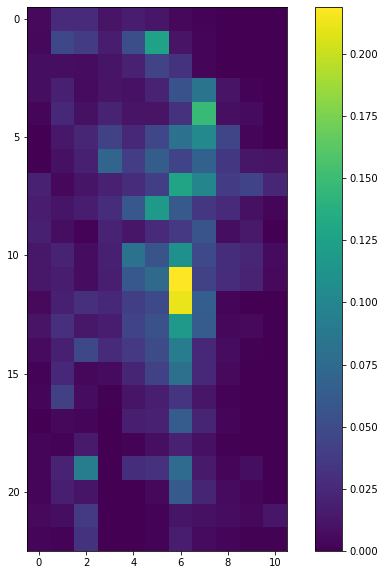

2020-11-21T13:28:27 | root | INFO | =====================================BEGIN=====================================
2020-11-21T13:28:27 | root | INFO | using time step: 1
2020-11-21T13:28:27 | root | INFO | finding best max_steps parameter...
2020-11-21T13:28:27 | root | INFO | best max_steps -> 8
fitted historic average: step (1) and max_steps (8)
2020-11-21T13:28:27 | root | INFO | finding best max_steps parameter...
2020-11-21T13:28:27 | root | INFO | best max_steps -> 8
fitted historic average: step (1) and max_steps (8)
2020-11-21T13:28:28 | root | INFO | f1_score: 0.4496828939517821 at index 289519, new threshold 0.03715060960182662
2020-11-21T13:28:28 | root | INFO | ======== ./data/processed/T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97/models/Historic Average/  ========
2020-11-21T13:28:29 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:4.974
                Model Name: Historic Average
                    NDCG:       

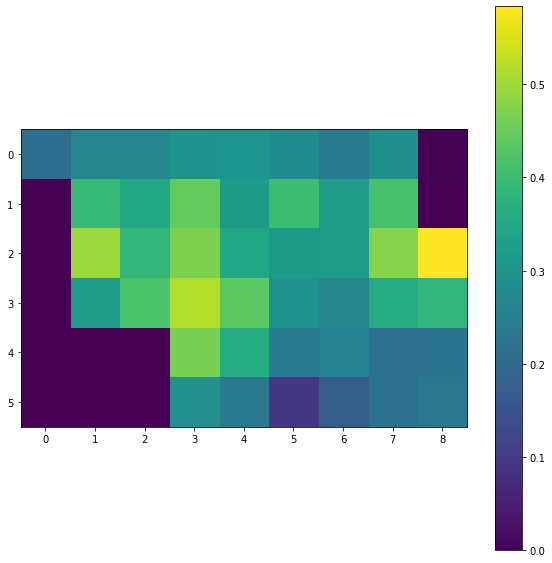

2020-11-21T13:28:32 | root | INFO | =====================================BEGIN=====================================
2020-11-21T13:28:32 | root | INFO | using time step: 1
2020-11-21T13:28:32 | root | INFO | finding best max_steps parameter...
2020-11-21T13:28:33 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:28:33 | root | INFO | finding best max_steps parameter...
2020-11-21T13:28:33 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:28:33 | root | INFO | f1_score: 0.9732333523514549 at index 1381, new threshold 0.06264416602505939
2020-11-21T13:28:33 | root | INFO | ======== ./data/processed/T24H-X1700M-Y1760M_2014-01-01_2019-01-01_#828/models/Historic Average/  ========
2020-11-21T13:28:33 | root | WARNING | time step 151 has no crime and roc_auc_score_per_time_slot[151] will be set to NaN => Only one class present in y_true. ROC AUC score is not defined in that case.
2020-11-21

/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2020-11-21T13:28:34 | root | WARNING | time step 151 has no crime and roc_auc_score_per_time_slot[151] will be set to NaN => Only one class present in y_true. ROC AUC score is not defined in that case.
2020-11-21T13:28:35 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:0.084
                Model Name: Global Average
                    NDCG:               0.95522                
                    ROC AUC:            0.89281                
                    Average Precision:  0.98859
                    Precision:          0.94390
                    Recall:             0.99952
                    Accuracy:           0.94473
                    MCC:                0.51644
                    PAI:                1.02316
                    MAE:                4.60342
                    RMSE:               6.26380      
            
2020-11-21T13:28:35 | root | INFO | =====================================END=============

/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2020-11-21T13:28:36 | root | WARNING | time step 151 has no crime and roc_auc_score_per_time_slot[151] will be set to NaN => Only one class present in y_true. ROC AUC score is not defined in that case.


/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2020-11-21T13:28:36 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:0.084
                Model Name: Previous Time Step
                    NDCG:               0.92439                
                    ROC AUC:            0.82481                
                    Average Precision:  0.97796
                    Precision:          0.92289
                    Recall:             1.00000
                    Accuracy:           0.92289
                    MCC:                0.00000
                    PAI:                1.00000
                    MAE:                4.60359
                    RMSE:               6.25613      
            
2020-11-21T13:28:36 | root | INFO | =====================================END=====================================

2020-11-21T13:28:36 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T1H-X2550M-Y2640M_2014-01-01_2017-01-01_#7ce
========================================================

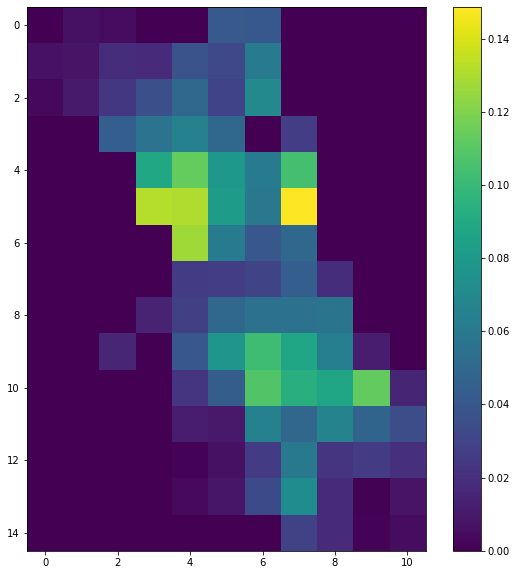

2020-11-21T13:28:37 | root | INFO | =====================================BEGIN=====================================
2020-11-21T13:28:37 | root | INFO | using time step: 24
2020-11-21T13:28:37 | root | INFO | finding best max_steps parameter...
2020-11-21T13:28:39 | root | INFO | best max_steps -> 9
fitted historic average: step (24) and max_steps (9)
2020-11-21T13:28:40 | root | INFO | finding best max_steps parameter...
2020-11-21T13:28:42 | root | INFO | best max_steps -> 9
fitted historic average: step (24) and max_steps (9)
2020-11-21T13:28:48 | root | INFO | f1_score: 0.4833337939304514 at index 358143, new threshold 0.05119764103420534
2020-11-21T13:28:48 | root | INFO | ======== ./data/processed/T1H-X2550M-Y2640M_2014-01-01_2017-01-01_#7ce/models/Historic Average/  ========
2020-11-21T13:29:18 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:3.912
                Model Name: Historic Average
                    NDCG:   

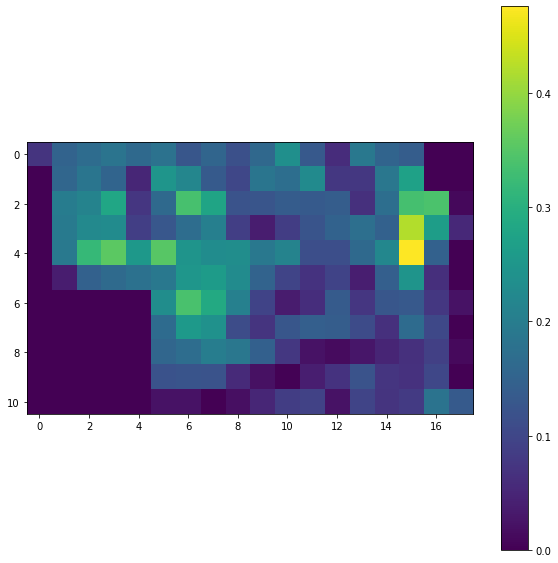

2020-11-21T13:30:17 | root | INFO | =====================================BEGIN=====================================
2020-11-21T13:30:17 | root | INFO | using time step: 1
2020-11-21T13:30:17 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:18 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:30:18 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:18 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:30:18 | root | INFO | f1_score: 0.8023325501483766 at index 81558, new threshold 0.082800063839949
2020-11-21T13:30:19 | root | INFO | ======== ./data/processed/T24H-X850M-Y880M_2012-01-01_2019-01-01_#826/models/Historic Average/  ========
2020-11-21T13:30:20 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:0.695
                Model Name: Historic Average
                    NDCG:          

/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2020-11-21T13:30:23 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:0.695
                Model Name: Previous Time Step
                    NDCG:               0.85020                
                    ROC AUC:            0.68380                
                    Average Precision:  0.73449
                    Precision:          0.59006
                    Recall:             1.00000
                    Accuracy:           0.59006
                    MCC:                0.00000
                    PAI:                1.00000
                    MAE:                1.24423
                    RMSE:               2.09692      
            
2020-11-21T13:30:23 | root | INFO | =====================================END=====================================

2020-11-21T13:30:23 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X425M-Y440M_2012-01-01_2019-01-01_#827
=========================================================

/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2020-11-21T13:30:23 | root | INFO | class distribution: {0.0: 0.7452604880688882, 0.15817959093978226: 0.187126474635378, 0.2507087200189668: 0.04826375326455744, 0.3163591818795645: 0.013064612069735797, 0.3672816362408709: 0.003886833781372301, 0.40888831095874906: 0.0013536903859262153, 0.4440662531938561: 0.0005054798612228017, 0.4745387728193468: 0.00024827230557534076, 0.5014174400379336: 0.00011934941167760597, 0.5254612271806531: 7.148200057696186e-05, 0.5472114783201966: 3.957039317653246e-05, 0.5670679018985313: 1.7232267996231876e-05, 0.5853340409128811: 1.4041107256188938e-05, 0.6022458441336384: 7.658785776103056e-06, 0.6179903562598378: 3.829392888051528e-06, 0.632718363759129: 6.382321480085881e-07, 0.6465532002105387: 1.2764642960171762e-06, 0.6595970309777159: 2.5529285920343524e-06, 0.6836408181204354: 1.2764642960171762e-06, 0.694774973212823: 6.382321480085881e-07, 0.7053910692599787: 6.382321480085881e-07, 0.7252474928383136: 6.382321480085881e-07, 0.74351363185266

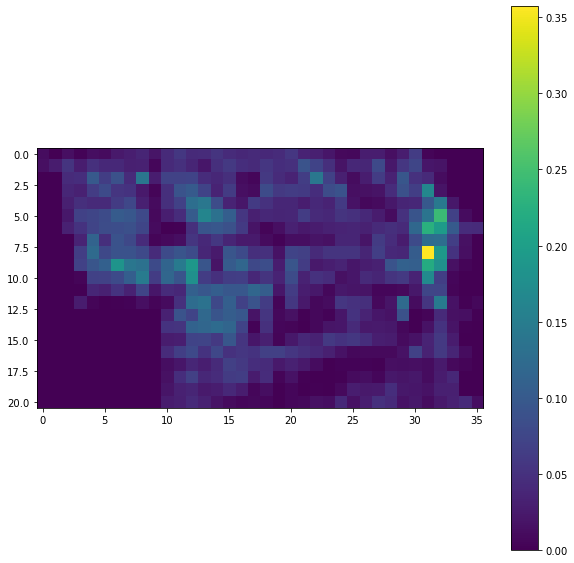

2020-11-21T13:30:23 | root | INFO | =====================================BEGIN=====================================
2020-11-21T13:30:23 | root | INFO | using time step: 1
2020-11-21T13:30:23 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:24 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:30:24 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:25 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:30:27 | root | INFO | f1_score: 0.526323099030405 at index 676049, new threshold 0.05084111384830918
2020-11-21T13:30:27 | root | INFO | ======== ./data/processed/T24H-X425M-Y440M_2012-01-01_2019-01-01_#827/models/Historic Average/  ========
2020-11-21T13:30:29 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:3.130
                Model Name: Historic Average
                    NDCG:        

/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2020-11-21T13:30:34 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:3.130
                Model Name: Previous Time Step
                    NDCG:               0.73086                
                    ROC AUC:            0.60571                
                    Average Precision:  0.33230
                    Precision:          0.24211
                    Recall:             1.00000
                    Accuracy:           0.24211
                    MCC:                0.00000
                    PAI:                1.00000
                    MAE:                0.34831
                    RMSE:               0.79156      
            
2020-11-21T13:30:34 | root | INFO | =====================================END=====================================

2020-11-21T13:30:34 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T168H-X1275M-Y1320M_2001-01-04_2019-01-03_#1f1
======================================================

/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2020-11-21T13:30:34 | root | INFO | class distribution: {0.0: 0.07588927076475172, 0.12042707175517926: 0.05144149749029035, 0.190872392803615: 0.04647946024632, 0.24085414351035853: 0.04445900807576847, 0.27962300129336704: 0.04101306498668132, 0.31129946455879426: 0.03925536220153784, 0.33808153264088675: 0.03694497967467398, 0.3612812152655378: 0.03544398605918203, 0.38174478560723: 0.034003394601255156, 0.4000500730485463: 0.032565823251206535, 0.4166092197697697: 0.031267176863557566, 0.43172653631397356: 0.030016852201960653, 0.4456331194622926: 0.02901417638638052, 0.45850860439606606: 0.027673248488436008, 0.4704953940969821: 0.026579969436508272, 0.48170828702071705: 0.025492730600337046, 0.4922411808798835: 0.023801470188515132, 0.5021718573624093: 0.02246054229057062, 0.5115654714722708: 0.021391424101668912, 0.5204771448037256: 0.020041435880089636, 0.5289539254445018: 0.019111242653587587, 0.537036291524949: 0.01780353594230386, 0.544759320271077: 0.01681898077399325, 0.55

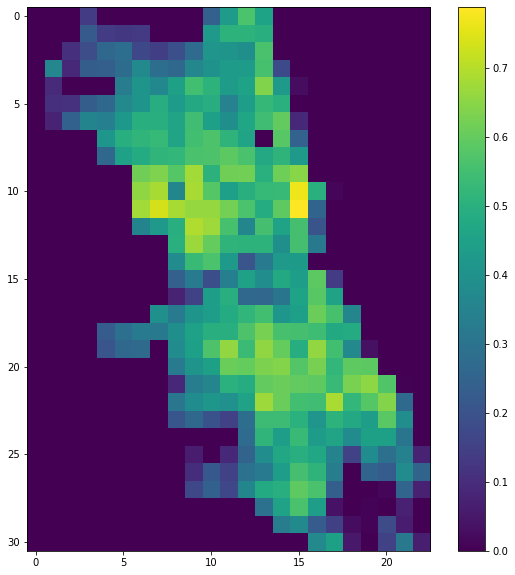

2020-11-21T13:30:34 | root | INFO | =====================================BEGIN=====================================
2020-11-21T13:30:34 | root | INFO | using time step: 1
2020-11-21T13:30:34 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:34 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:30:34 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:34 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:30:35 | root | INFO | f1_score: 0.9775158113295177 at index 14571, new threshold 0.08451539872296752
2020-11-21T13:30:35 | root | INFO | ======== ./data/processed/T168H-X1275M-Y1320M_2001-01-04_2019-01-03_#1f1/models/Historic Average/  ========
2020-11-21T13:30:35 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:0.111
                Model Name: Historic Average
                    NDCG:     

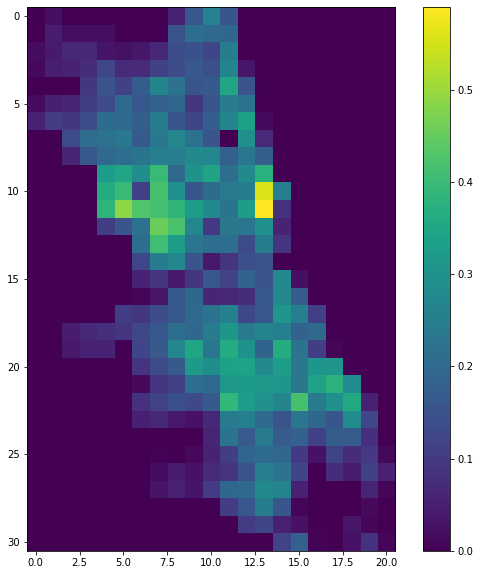

2020-11-21T13:30:36 | root | INFO | =====================================BEGIN=====================================
2020-11-21T13:30:36 | root | INFO | using time step: 1
2020-11-21T13:30:36 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:37 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:30:37 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:37 | root | INFO | best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2020-11-21T13:30:39 | root | INFO | f1_score: 0.8464643006112978 at index 182868, new threshold 0.08413431552572098
2020-11-21T13:30:39 | root | INFO | ======== ./data/processed/T24H-X1275M-Y1320M_2012-01-01_2019-01-01_#939/models/Historic Average/  ========
2020-11-21T13:30:40 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:0.636
                Model Name: Historic Average
                    NDCG:     

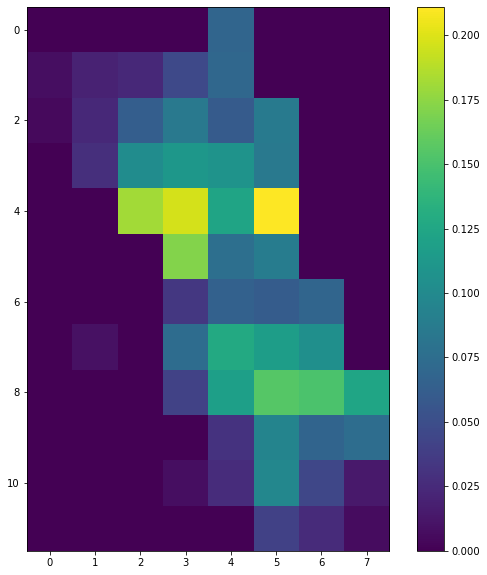

2020-11-21T13:30:44 | root | INFO | =====================================BEGIN=====================================
2020-11-21T13:30:44 | root | INFO | using time step: 24
2020-11-21T13:30:44 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:46 | root | INFO | best max_steps -> 9
fitted historic average: step (24) and max_steps (9)
2020-11-21T13:30:47 | root | INFO | finding best max_steps parameter...
2020-11-21T13:30:49 | root | INFO | best max_steps -> 9
fitted historic average: step (24) and max_steps (9)
2020-11-21T13:30:52 | root | INFO | f1_score: 0.6016803189663025 at index 251098, new threshold 0.06487139604933753
2020-11-21T13:30:52 | root | INFO | ======== ./data/processed/T1H-X3400M-Y3520M_2014-01-01_2017-01-01_#7cd/models/Historic Average/  ========
2020-11-21T13:31:20 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:2.133
                Model Name: Historic Average
                    NDCG:   

/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2020-11-21T13:32:17 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:2.133
                Model Name: Previous Time Step
                    NDCG:               0.64955                
                    ROC AUC:            0.61437                
                    Average Precision:  0.41363
                    Precision:          0.31915
                    Recall:             1.00000
                    Accuracy:           0.31915
                    MCC:                0.00000
                    PAI:                1.00000
                    MAE:                0.46262
                    RMSE:               0.87866      
            
2020-11-21T13:32:18 | root | INFO | =====================================END=====================================



In [5]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()

    conf.data_path = f"./data/processed/{data_sub_path}/"

    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("\n====================================================" + \
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n" + \
             "==============================================================" + \
             "===t==================================================")

    log.info("=====================================BEGIN=====================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)

    # CRIME DATA
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

    # LOG CLASS DISTRIBUTION
    vals, counts = np.unique(data_group.targets, return_counts=True)
    counts = counts / np.sum(counts)
    dist = dict(zip(vals, counts))
    log.info(f"class distribution: {dist}")

    test_set_size = data_group.testing_set.target_shape[0]
    crimes = data_group.shaper.unsqueeze(data_group.crimes)
    im(crimes.mean(0)[0])
    crimes = data_group.crimes
    t_range = data_group.t_range

    # -----------HISTORIC AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Historic Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for
    freqstr = DatetimeFreq.convert(t_range)
    time_step = 1
    if freqstr == DatetimeFreq.Day:
        time_step = 1
    if freqstr == DatetimeFreq.Hour:
        time_step = 24
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    ha = HistoricAverage(step=time_step)
    all_crimes = data_group.crimes[:, 0]
    all_targets = data_group.targets
    all_labels = data_group.labels
    all_crimes_ha = ha.fit_transform(data_group.crimes[:, 0:1])[:, 0]

    ha.fit(data_group.crimes[:, 0:1])
    ha.max_steps = -1
    all_crimes_ha = ha.transform(data_group.crimes[:, 0:1])[:, 0]

    all_t_range = data_group.t_range

    tst_crimes_ha = all_crimes_ha[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_y_score = all_crimes_ha[time_step + 1:-test_set_size]  # skip all the nan values
    trn_y_true = all_targets[time_step + 1:-test_set_size]
    trn_y_class = all_labels[time_step + 1:-test_set_size]

    thresh = best_threshold(y_class=trn_y_class,
                            y_score=trn_y_score)  # should only come from the train predictions

    tst_y_true = tst_targets
    tst_y_count = data_group.to_counts(tst_y_true)
    tst_y_score = tst_crimes_ha
    tst_y_pred = get_y_pred(thresh, tst_y_score)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_y_score = np.expand_dims(tst_y_score, axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_count=tst_y_count,
                 y_pred=tst_y_pred,
                 y_score=tst_y_score,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,
                 conf=conf)

    log.info("=====================================END=====================================\n")
    # -----------HISTORIC AVERAGE

    # -----------GLOBAL AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Global Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    test_set_size = data_group.testing_set.target_shape[0]

    all_crimes = data_group.crimes[:, 0]
    all_targets = data_group.targets
    all_labels = data_group.labels

    trn_crimes = all_crimes[:-test_set_size]
    trn_targets = all_targets[:-test_set_size]
    trn_labels = all_labels[:-test_set_size]

    tst_crimes = all_crimes[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_mean = np.mean(trn_crimes, axis=0, keepdims=True)  # keep dims used to make scalar product easy
    trn_ones = np.ones_like(trn_crimes, dtype=np.float)
    trn_y_score = trn_mean * trn_ones

    thresh = best_threshold(y_class=trn_labels,
                            y_score=trn_y_score)  # should only come from the train predictions

    # only use the training sets - mean
    tst_ones = np.ones_like(tst_crimes, dtype=np.float)
    tst_y_score = trn_mean * tst_ones

    tst_y_count = data_group.to_counts(tst_targets)
    tst_y_pred = get_y_pred(thresh, tst_y_score)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_y_score = np.expand_dims(tst_y_score, axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_count=tst_y_count,
                 y_pred=tst_y_pred,
                 y_score=tst_y_score,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,
                 conf=conf)

    log.info("=====================================END=====================================\n")
    # -----------GLOBAL AVERAGE

    # ------------PREVIOUS TIME STEP
    # Create model folder and setup logging for model
    conf.model_name = "Previous Time Step"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"

    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)

    log.info("=====================================BEGIN=====================================")

    test_set_size = data_group.testing_set.target_shape[0]

    all_y_score = data_group.crimes[:, 0]
    all_targets = data_group.targets
    all_labels = data_group.labels
    all_t_range = data_group.t_range

    tst_y_score = all_y_score[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_y_score = all_y_score[:-test_set_size]  # skip all the nan values
    trn_y_true = all_targets[:-test_set_size]
    trn_y_class = all_labels[:-test_set_size]

    thresh = best_threshold(y_class=trn_y_class,
                            y_score=trn_y_score)  # should only come from the train predictions

    tst_y_count = data_group.to_counts(tst_y_true)
    tst_y_pred = get_y_pred(thresh, tst_y_score)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)f
    tst_y_score = np.expand_dims(tst_y_score, axis=1)

    save_metrics(y_count=tst_y_count,
                 y_pred=tst_y_pred,
                 y_score=tst_y_score,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,
                 conf=conf)

    log.info("=====================================END=====================================\n")
    # ------------PREVIOUS TIME STEP

#     # #    --------------    --------------    --------------    --------------    --------------    --------------

#     # ------------Uniform Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Uni. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"

#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for
#     freqstr = DatetimeFreq.convert(t_range)
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30 * time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len = time_step

#     ma = UniformMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:, 0]
#     all_targets = data_group.targets
#     all_labels = data_group.labels
#     all_y_score = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_y_score = all_y_score[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_y_score = all_y_score[time_step + 1:-test_set_size]  # skip all the nan values
#     trn_y_true = all_targets[time_step + 1:-test_set_size]
#     trn_y_class = all_labels[time_step + 1:-test_set_size]

#     thresh = best_threshold(y_class=trn_y_class,
#                             y_score=trn_y_score)  # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_y_count = data_group.to_counts(tst_y_true)
#     tst_y_score = tst_y_score
#     tst_y_pred = get_y_pred(thresh, tst_y_score)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
#     tst_y_score = np.expand_dims(tst_y_score, axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_count=tst_y_count,
#                  y_pred=tst_y_pred,
#                  y_score=tst_y_score,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,
#                  conf=conf)

#     log.info("=====================================END=====================================\n")
#     # ------------Uniform Moving Average

#     #############################################################################################################

#     # ------------Exponential Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Exp. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"

#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for
#     freqstr = DatetimeFreq.convert(t_range)
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30 * time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     alpha = 1e-2
#     window_len = time_step

#     ma = ExponentialMovingAverage(alpha=alpha, window_len=window_len)

#     all_crimes = data_group.crimes[:, 0]
#     all_targets = data_group.targets
#     all_labels = data_group.labels
#     all_y_score = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_y_score = all_y_score[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_y_score = all_y_score[time_step + 1:-test_set_size]  # skip all the nan values
#     trn_y_true = all_targets[time_step + 1:-test_set_size]
#     trn_y_class = all_labels[time_step + 1:-test_set_size]

#     thresh = best_threshold(y_class=trn_y_class,
#                             y_score=trn_y_score)  # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_y_count = data_group.to_counts(tst_y_true)
#     tst_y_score = tst_y_score
#     tst_y_pred = get_y_pred(thresh, tst_y_score)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
#     tst_y_score = np.expand_dims(tst_y_score, axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_count=tst_y_count,
#                  y_pred=tst_y_pred,
#                  y_score=tst_y_score,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,
#                  conf=conf)

#     log.info("=====================================END=====================================\n")
#     # ------------Exponential Moving Average

#     # ------------Triangular Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Tri. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"

#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for
#     freqstr = DatetimeFreq.convert(t_range)

#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30 * time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len = time_step

#     ma = TriangularMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:, 0]
#     all_targets = data_group.targets
#     all_labels = data_group.labels
#     all_y_score = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_y_score = all_y_score[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_y_score = all_y_score[time_step + 1:-test_set_size]  # skip all the nan values
#     trn_y_true = all_targets[time_step + 1:-test_set_size]
#     trn_y_class = all_labels[time_step + 1:-test_set_size]

#     thresh = best_threshold(y_class=trn_y_class,
#                             y_score=trn_y_score)  # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_y_count = data_group.to_counts(tst_y_true)
#     tst_y_score = tst_y_score
#     tst_y_pred = get_y_pred(thresh, tst_y_score)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
#     tst_y_score = np.expand_dims(tst_y_score, axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_count=tst_y_count,
#                  y_pred=tst_y_pred,
#                  y_score=tst_y_score,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,
#                  conf=conf)

#     log.info("=====================================END=====================================\n")
#     # ------------Triangular Moving Average

In [3]:
from models.model_result import compare_all_models

T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.770923,0.519050,0.811395,0.498601,0.423231,0.608238,0.499143,0.795671,0.385698,2.804940,0.654759,0.238585
Global Average,0.770235,0.517482,0.810393,0.493777,0.433649,0.580852,0.496571,0.802853,0.383418,2.897413,0.655142,0.238543
Ind-Hawkes Model,0.770105,0.516329,0.809572,0.498062,0.435428,0.578166,0.496746,0.803902,0.383816,2.928152,0.601779,0.261904
Previous Time Step,0.650002,0.282538,0.624644,0.270566,0.368044,0.368181,0.368113,0.788413,0.241045,2.569801,0.649877,0.238042


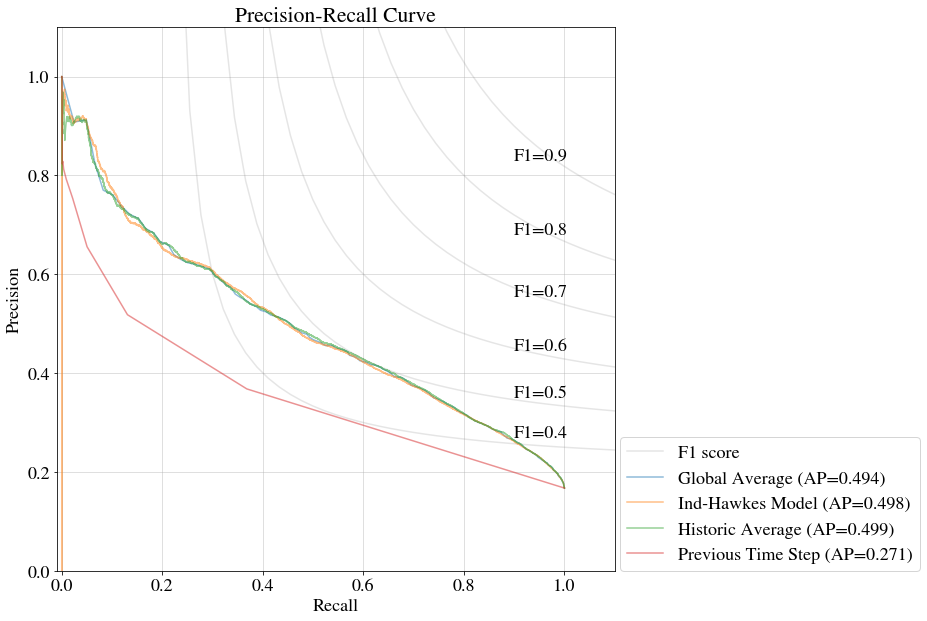

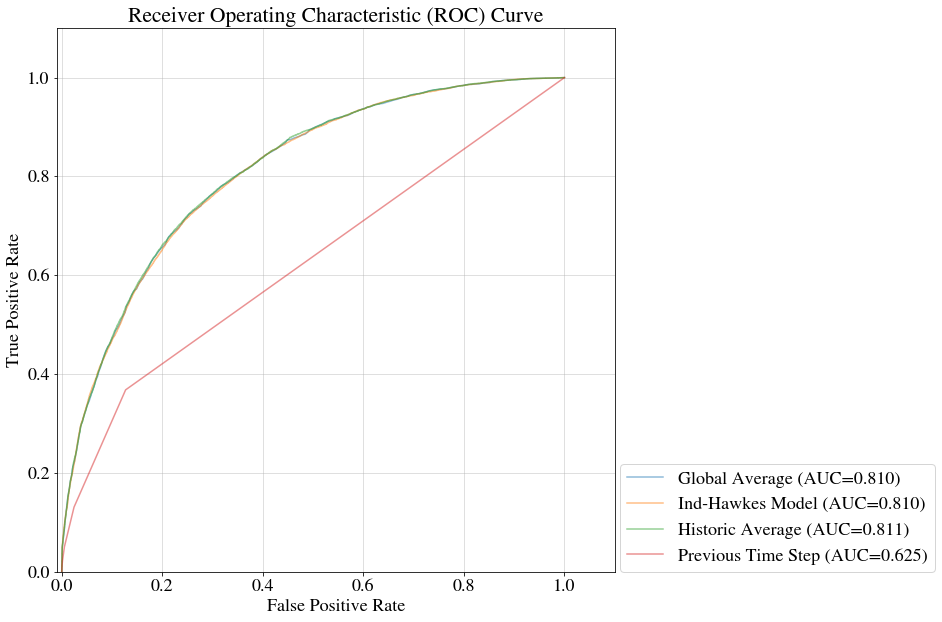

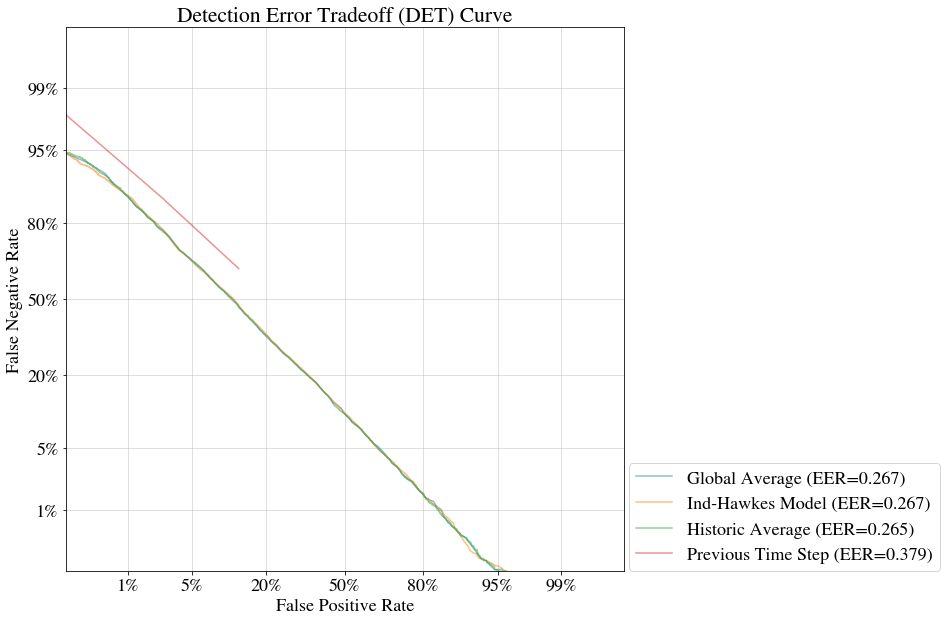

---------------------------------------------------------------------------------------------------- 

T24H-X1700M-Y1760M_2014-01-01_2019-01-01_#828


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.955609,0.989883,0.892652,0.989151,0.943901,0.999520,0.970915,0.944733,0.516437,1.023163,6.263646,4.603981
Global Average,0.955217,0.989831,0.892805,0.988594,0.943901,0.999520,0.970915,0.944733,0.516437,1.023163,6.263801,4.603416
Previous Time Step,0.924389,0.977829,0.824806,0.977959,0.922892,1.000000,0.959900,0.922892,0.000000,1.000000,6.256132,4.603594
Ind-Hawkes Model,0.869585,0.988537,0.882543,0.987881,0.945300,0.998148,0.971005,0.944986,0.519141,1.025730,5.862637,4.081975


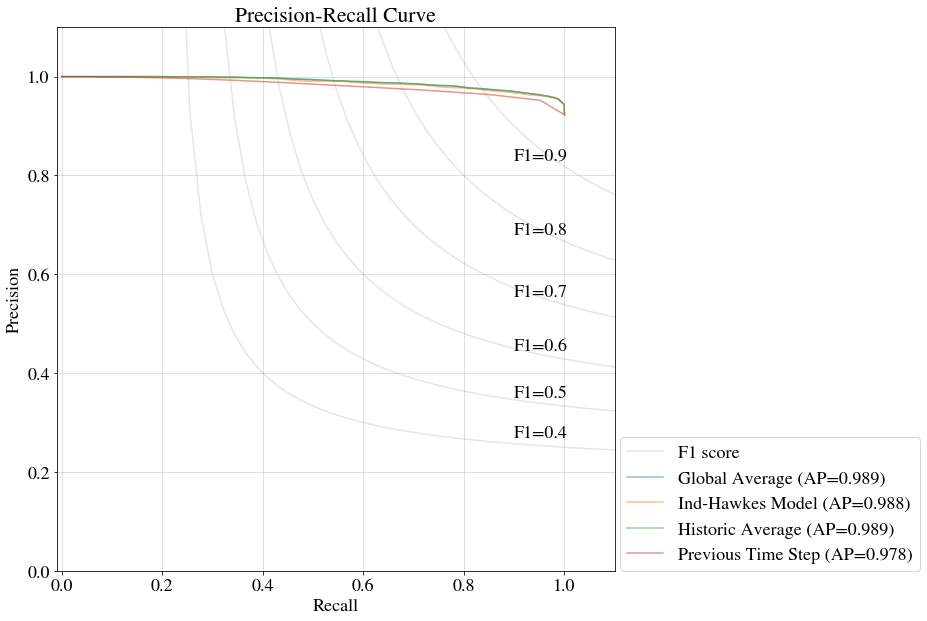

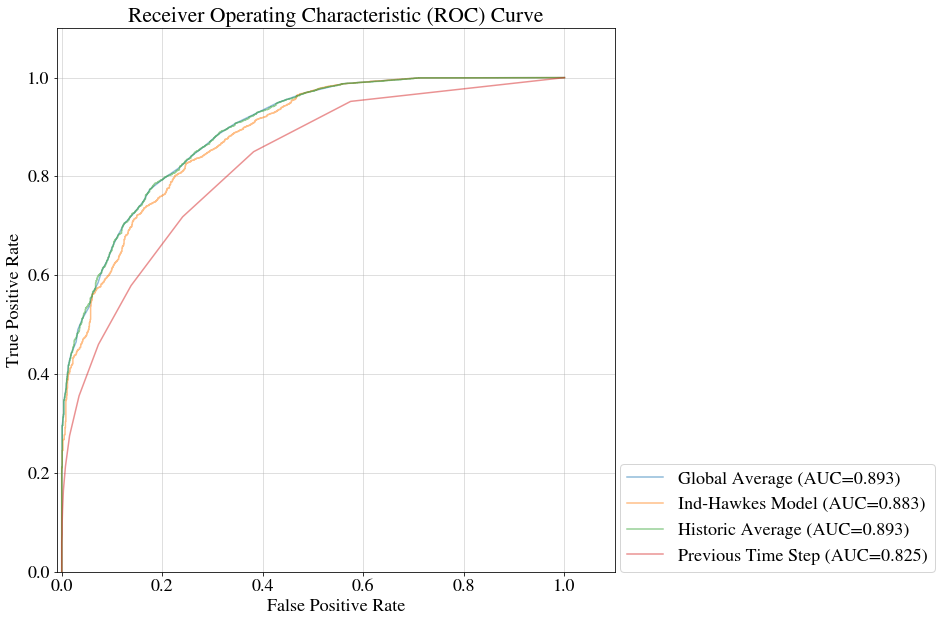

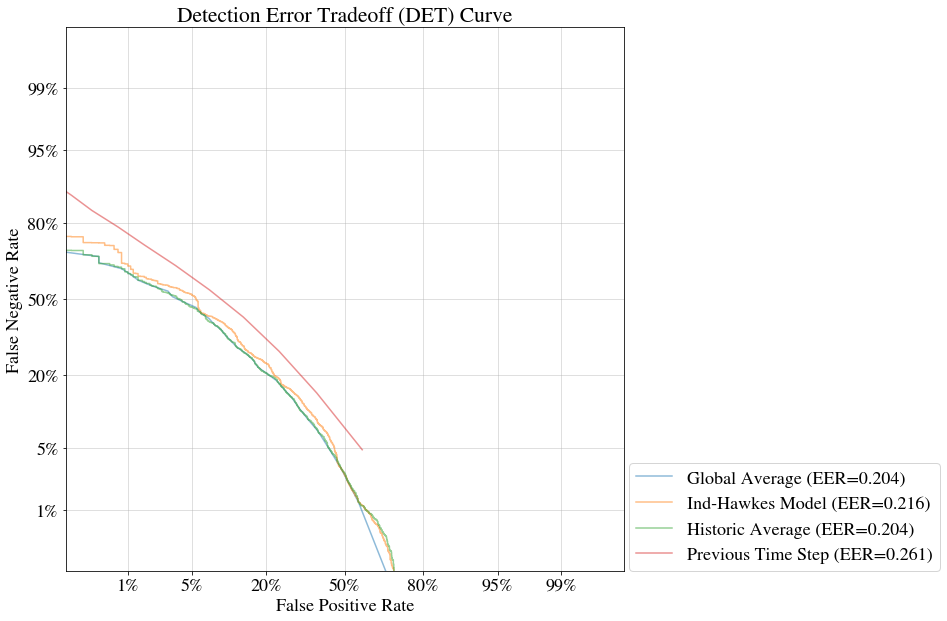

---------------------------------------------------------------------------------------------------- 

T1H-X2550M-Y2640M_2014-01-01_2017-01-01_#7ce


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.675668,0.452320,0.765756,0.450654,0.383750,0.654098,0.483713,0.715717,0.326155,2.010857,0.604195,0.273351
Global Average,0.673363,0.450470,0.743988,0.399999,0.353731,0.659012,0.460359,0.685439,0.291462,1.844392,0.607679,0.276165
Ind-Hawkes Model,0.673008,0.449022,0.757852,0.442457,0.373592,0.649360,0.474305,0.706934,0.312433,1.958410,0.593107,0.281561
Previous Time Step,0.576200,0.270951,0.586590,0.261741,0.336673,0.336642,0.336658,0.729902,0.167085,1.790478,0.608262,0.272325


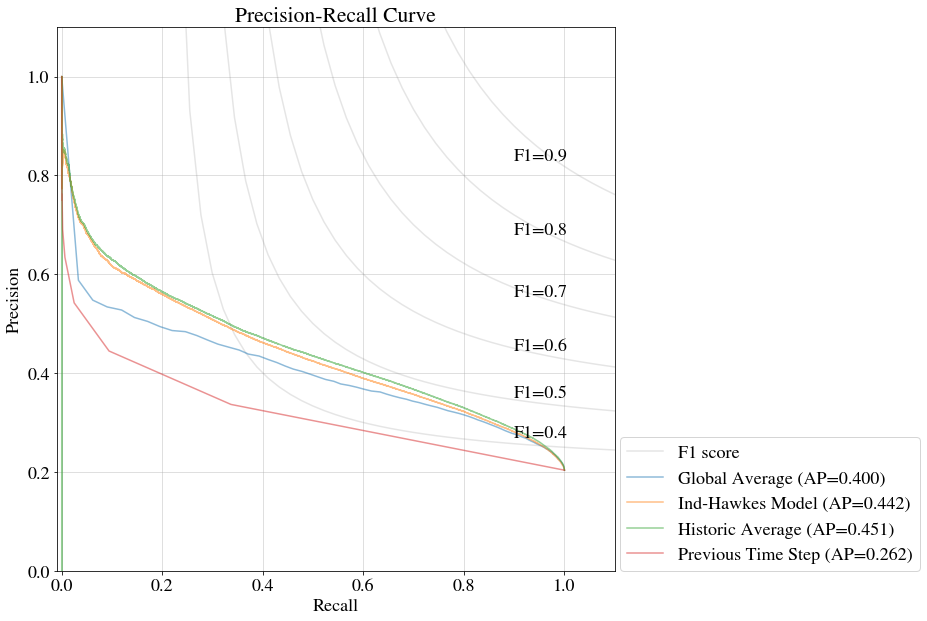

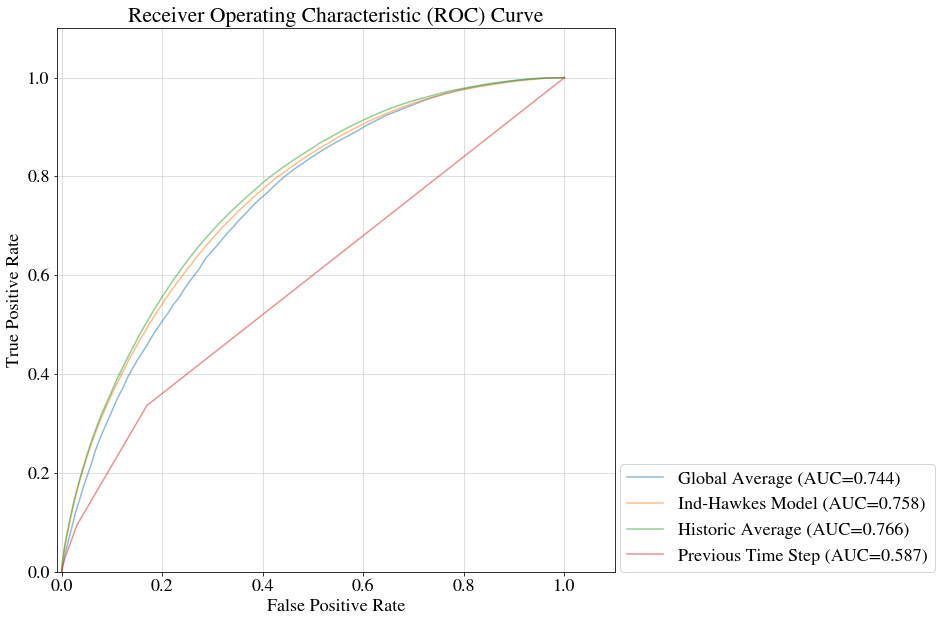

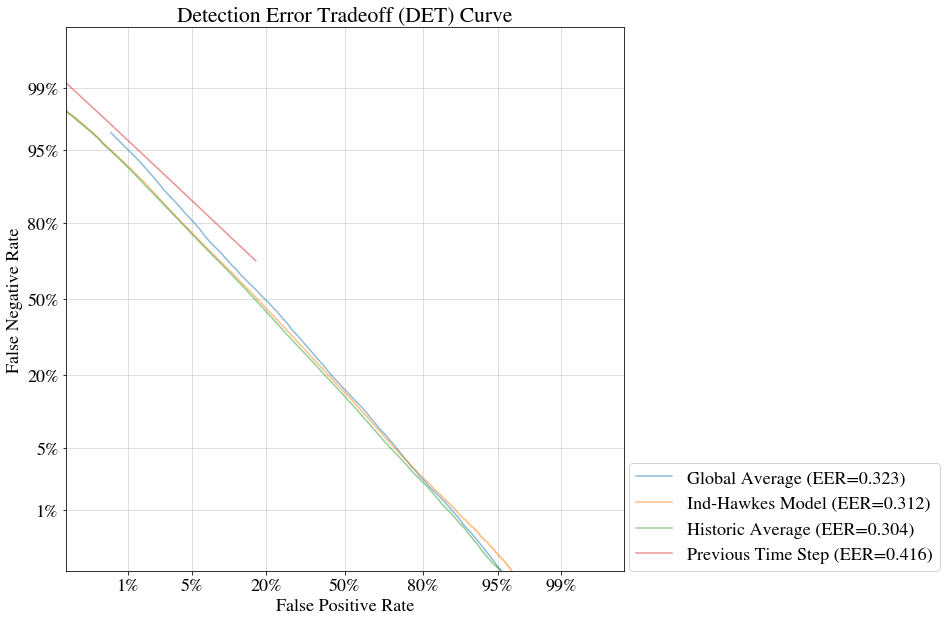

---------------------------------------------------------------------------------------------------- 

T24H-X850M-Y880M_2012-01-01_2019-01-01_#826


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.899369,0.845069,0.795136,0.841644,0.716020,0.887351,0.792532,0.725870,0.422461,1.279871,2.099060,1.246949
Global Average,0.898478,0.844222,0.794518,0.839837,0.687087,0.931549,0.790857,0.709279,0.394562,1.202691,2.098983,1.246869
Ind-Hawkes Model,0.890832,0.841123,0.791577,0.838329,0.697968,0.914053,0.791528,0.715895,0.404575,1.232031,1.854985,1.097124
Previous Time Step,0.850204,0.734896,0.683800,0.734490,0.590059,1.000000,0.742185,0.590059,0.000000,1.000000,2.096917,1.244226


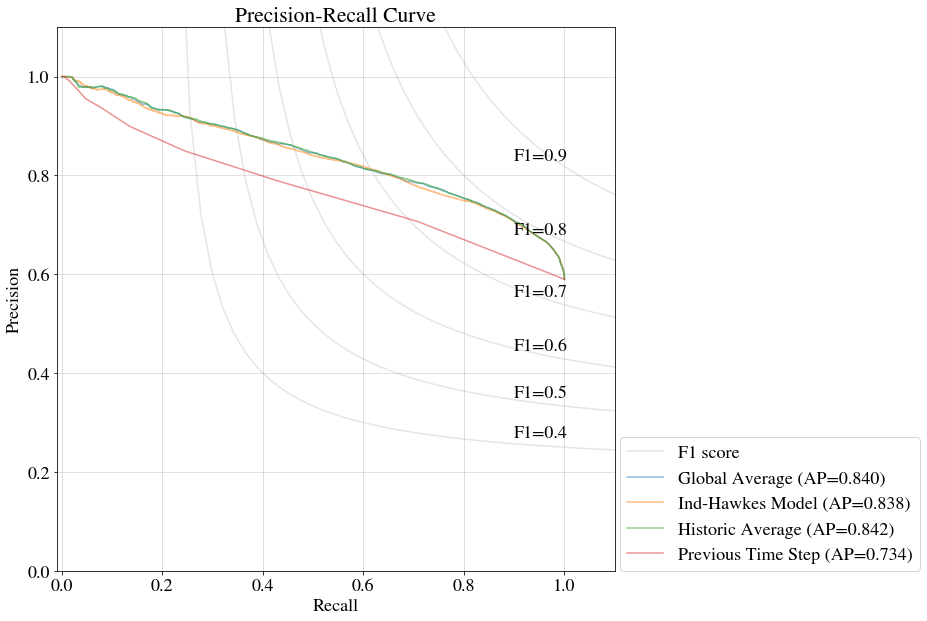

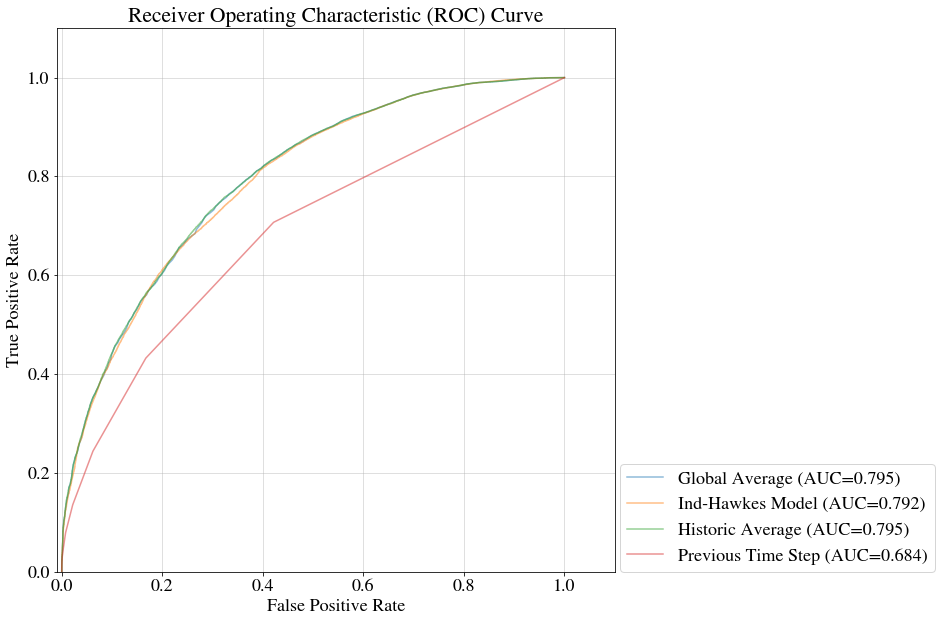

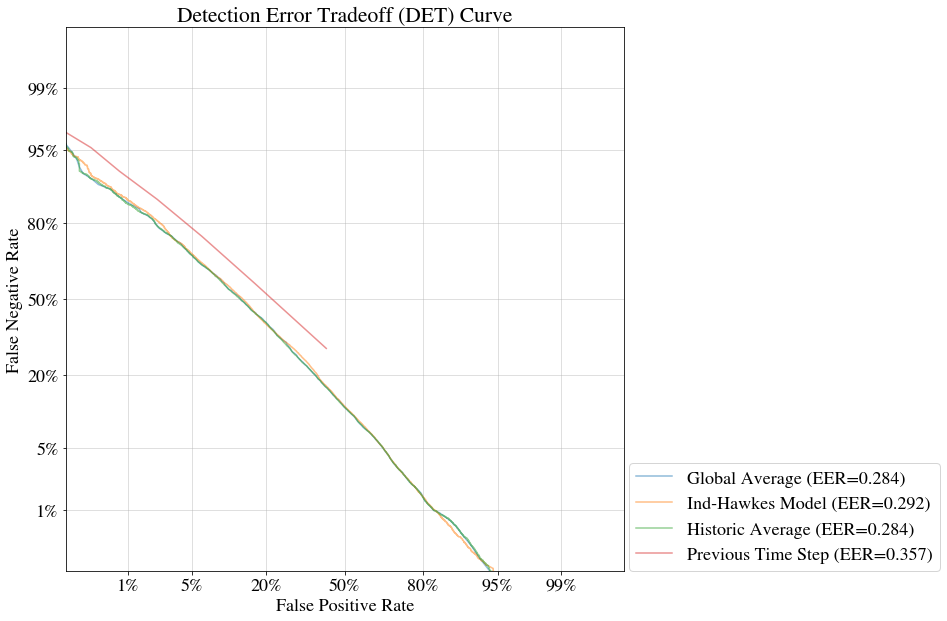

---------------------------------------------------------------------------------------------------- 

T24H-X425M-Y440M_2012-01-01_2019-01-01_#827


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.820942,0.522364,0.758734,0.516528,0.426902,0.642980,0.513121,0.704581,0.326823,1.940859,0.792267,0.352349
Global Average,0.819023,0.519837,0.757551,0.513217,0.404315,0.694688,0.511141,0.678284,0.319587,1.806710,0.792356,0.352560
Ind-Hawkes Model,0.812544,0.515363,0.755845,0.510343,0.399889,0.700375,0.509100,0.672990,0.316044,1.779956,0.715724,0.391117
Previous Time Step,0.730862,0.334770,0.605710,0.332304,0.242108,1.000000,0.389834,0.242108,0.000000,1.000000,0.791561,0.348306


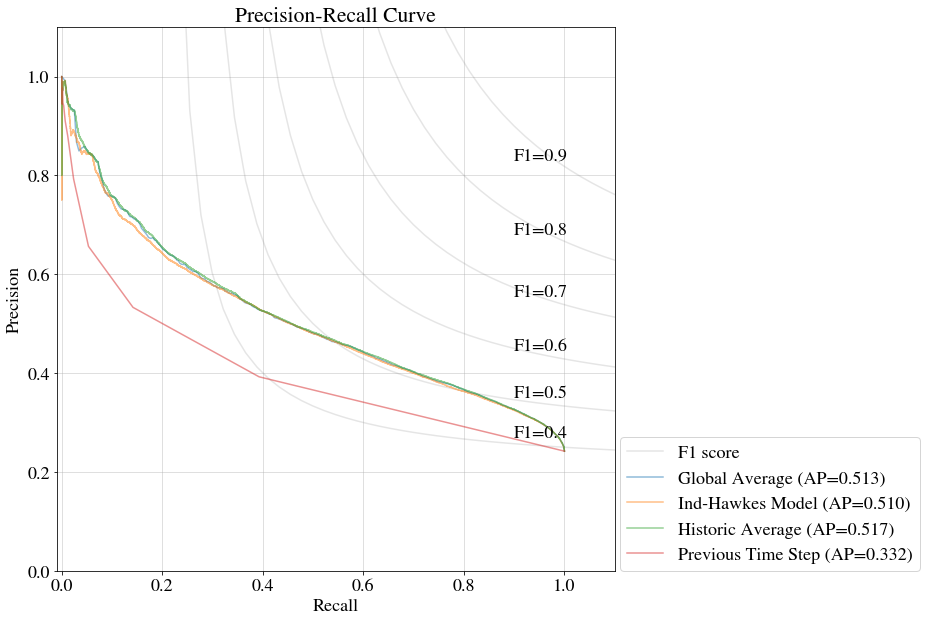

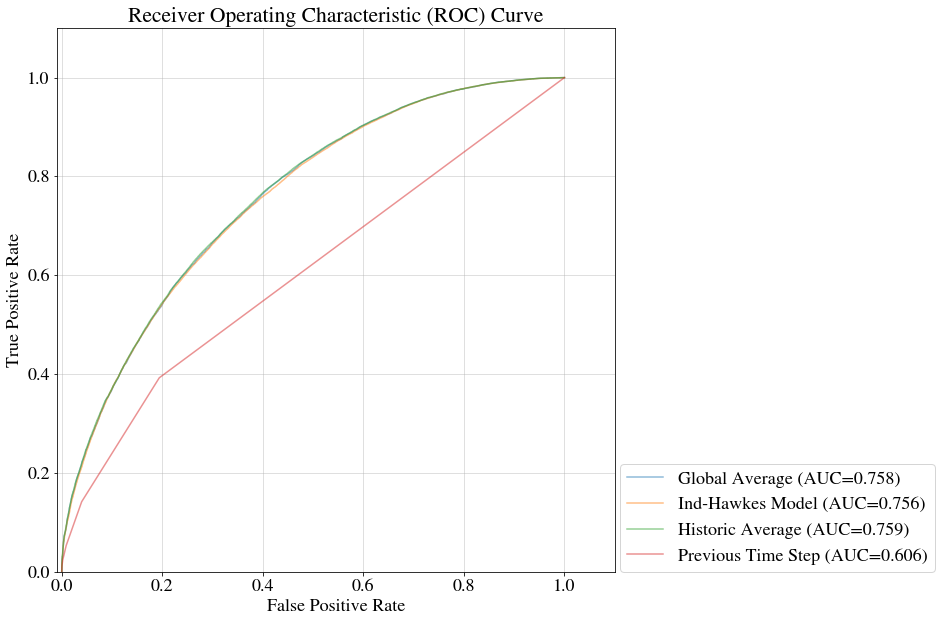

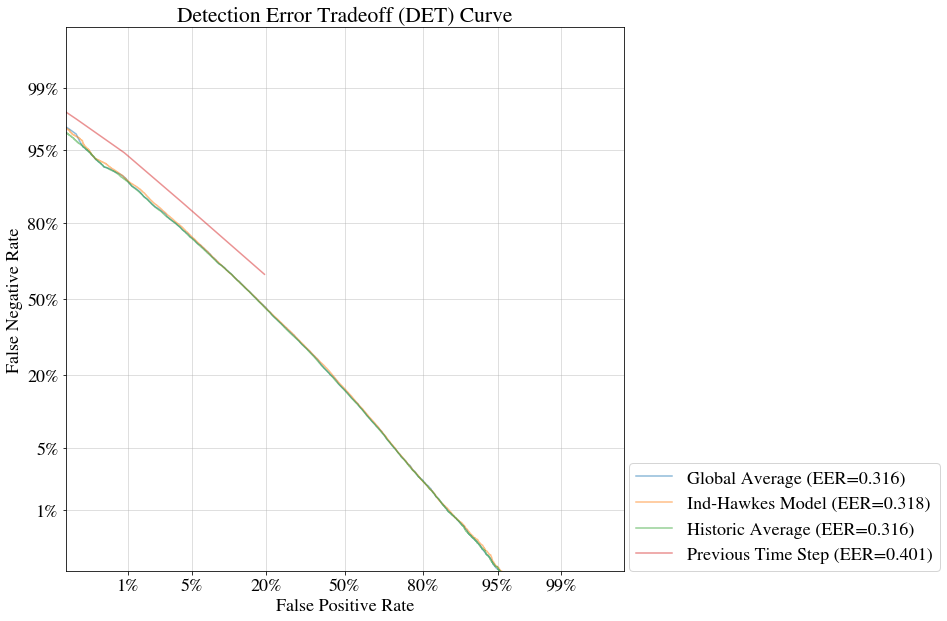

---------------------------------------------------------------------------------------------------- 

T168H-X1275M-Y1320M_2001-01-04_2019-01-03_#1f1


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.979311,0.996138,0.965323,0.996012,0.949124,0.988546,0.968434,0.941983,0.632281,1.065182,16.048801,10.484633
Global Average,0.978799,0.996127,0.965351,0.995948,0.941612,0.992574,0.966422,0.937904,0.595064,1.052935,16.047674,10.483032
Previous Time Step,0.976513,0.990231,0.935421,0.990174,0.956276,0.956576,0.956426,0.921530,0.562401,1.102260,16.083819,10.536962
Ind-Hawkes Model,0.754574,0.995210,0.961850,0.995102,0.940241,0.993140,0.965967,0.936997,0.587101,1.050841,15.766353,10.045884


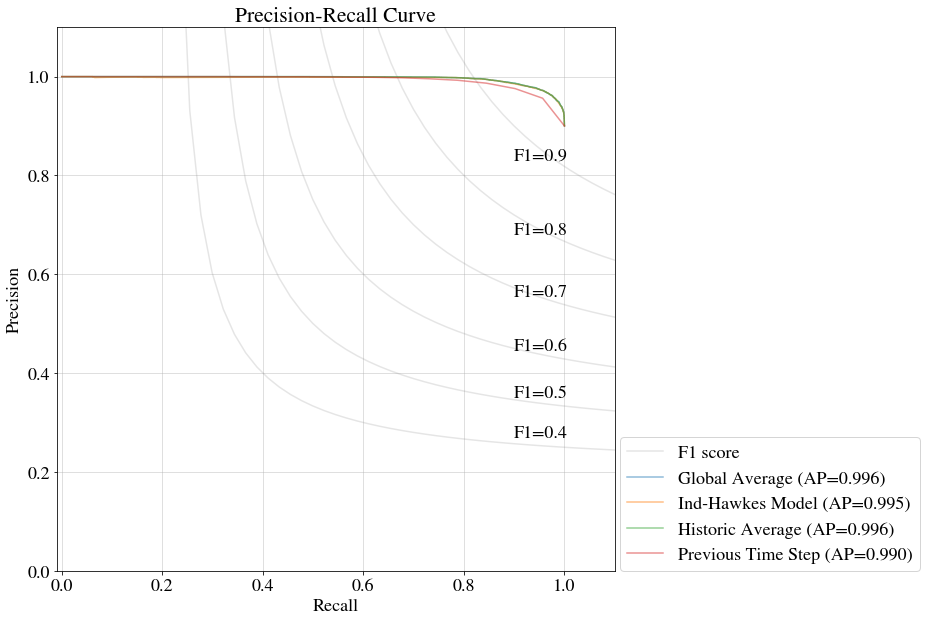

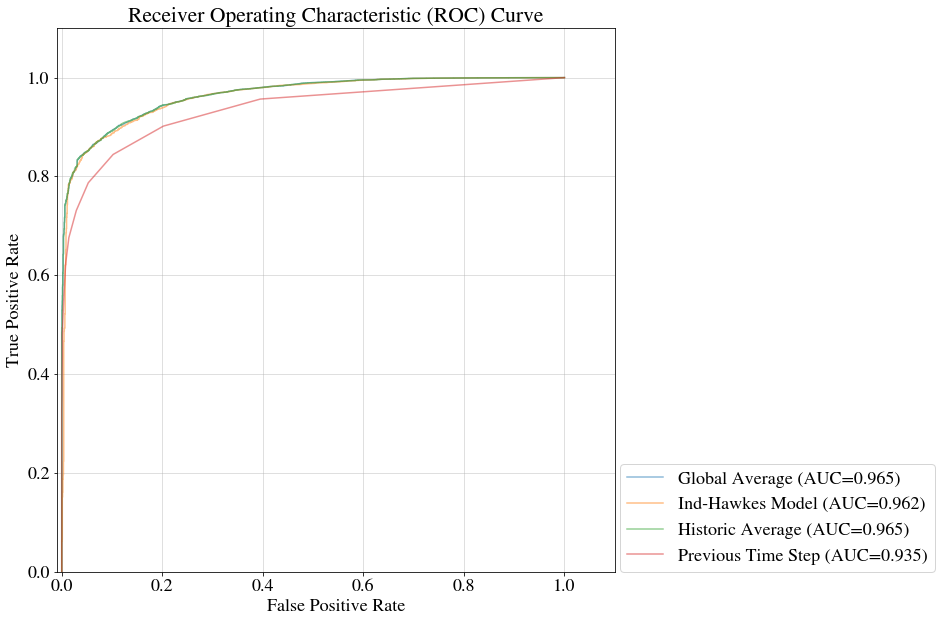

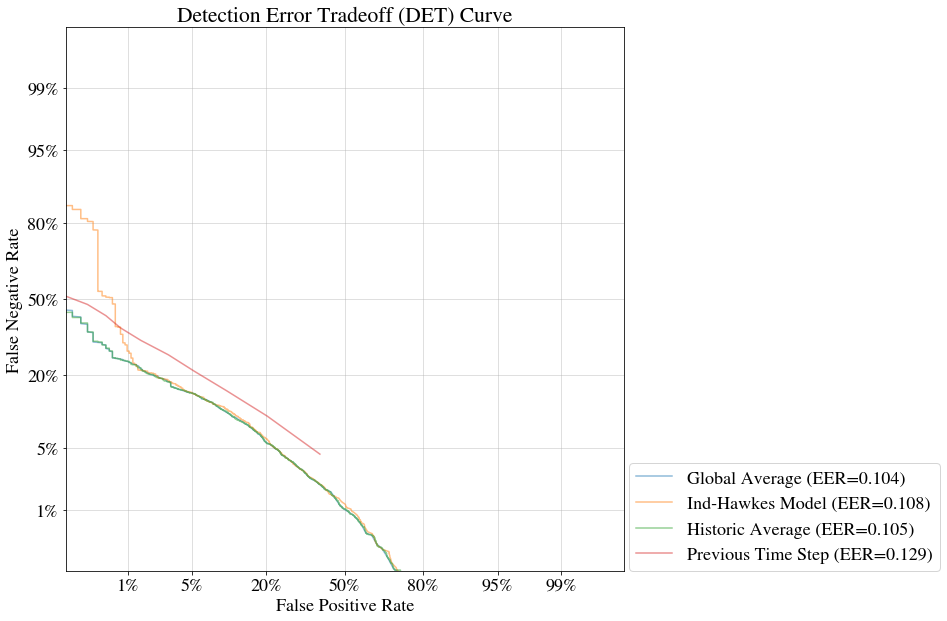

---------------------------------------------------------------------------------------------------- 

T24H-X1275M-Y1320M_2012-01-01_2019-01-01_#939


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.926832,0.895040,0.849905,0.893728,0.763371,0.916357,0.832897,0.775190,0.517808,1.308086,2.509605,1.474547
Global Average,0.926412,0.894698,0.849687,0.893016,0.762350,0.917247,0.832656,0.774581,0.516574,1.304972,2.508974,1.474028
Ind-Hawkes Model,0.903300,0.892226,0.847450,0.891203,0.759056,0.919604,0.831652,0.772372,0.511999,1.297588,2.241650,1.273637
Previous Time Step,0.883596,0.793694,0.741649,0.794297,0.760071,0.759793,0.759932,0.706496,0.382394,1.376647,2.514492,1.477376


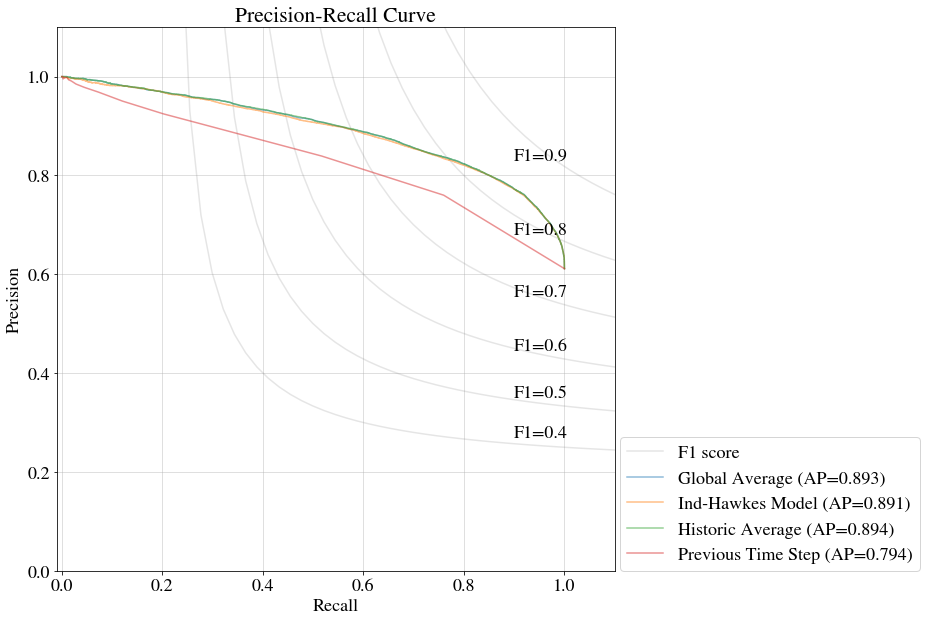

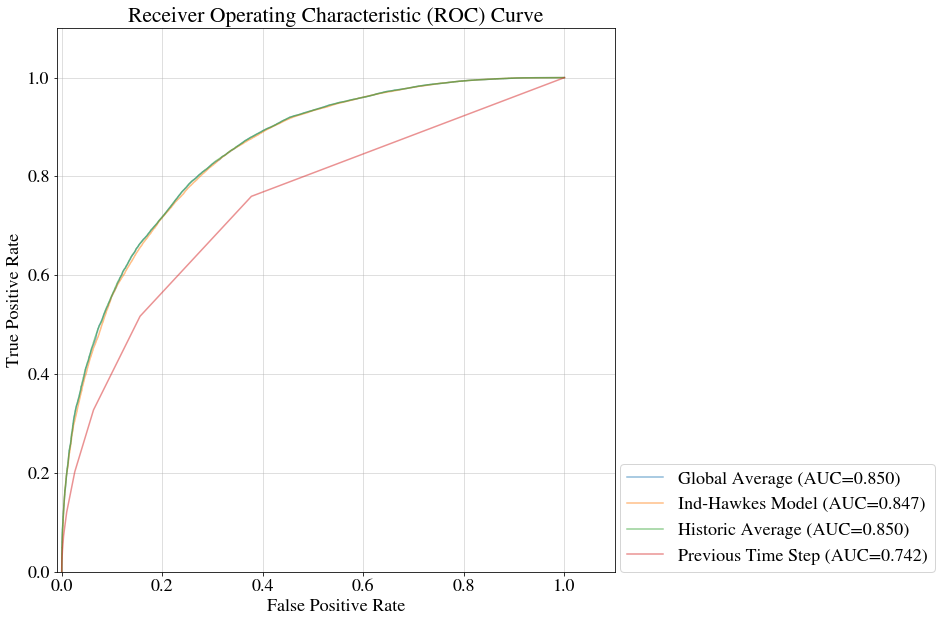

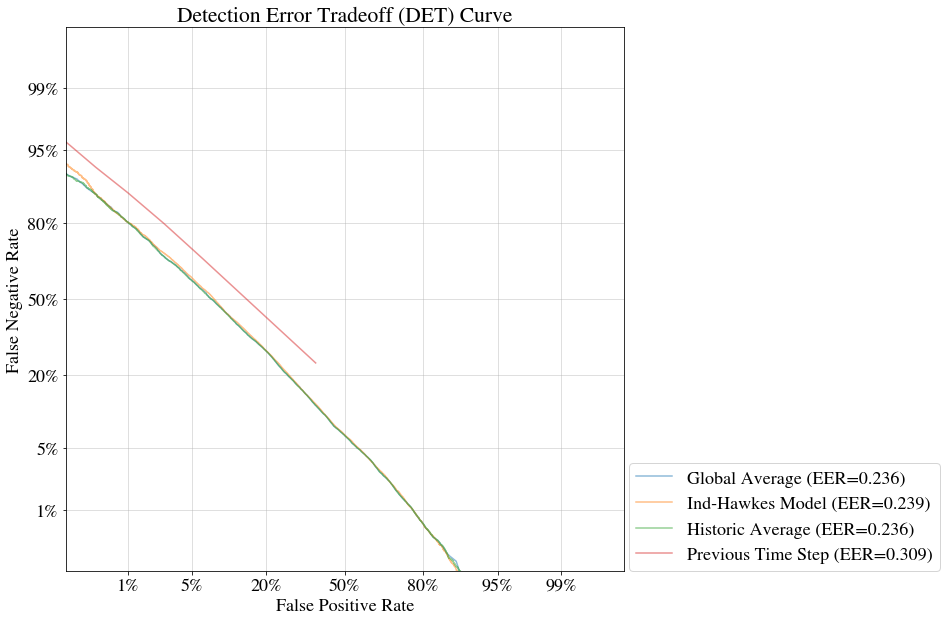

---------------------------------------------------------------------------------------------------- 

T1H-X3400M-Y3520M_2014-01-01_2017-01-01_#7cd


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.744610,0.594146,0.767960,0.599773,0.492021,0.767551,0.599650,0.672902,0.369272,1.637903,0.875495,0.464481
Global Average,0.744180,0.593606,0.741029,0.543517,0.442192,0.831312,0.577304,0.611478,0.323271,1.444136,0.881671,0.469950
Ind-Hawkes Model,0.740994,0.590804,0.760160,0.593471,0.479496,0.767188,0.590148,0.659907,0.351375,1.594083,0.852926,0.470643
Previous Time Step,0.649550,0.417291,0.614368,0.413630,0.319153,1.000000,0.483875,0.319153,0.000000,1.000000,0.878663,0.462621


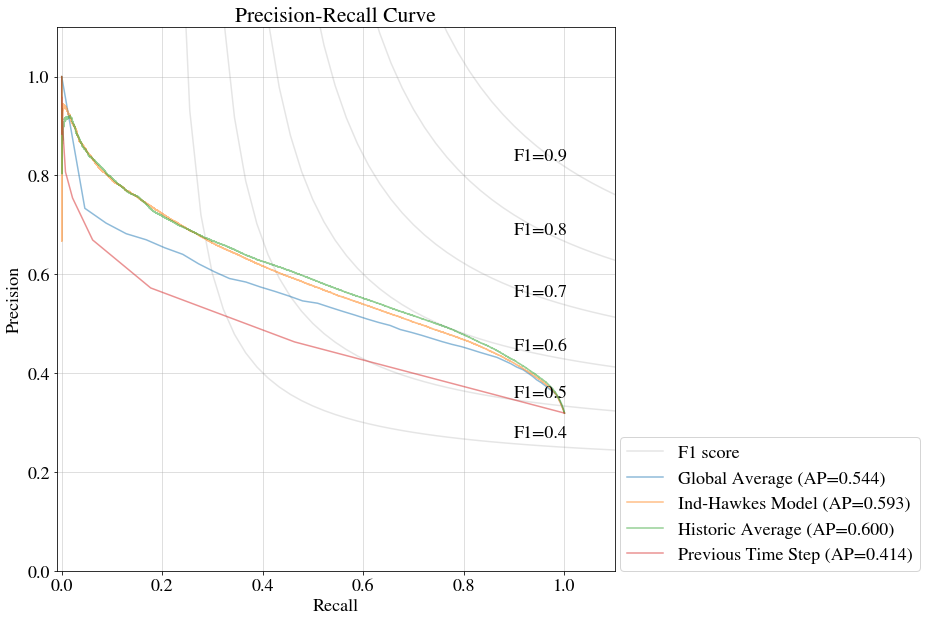

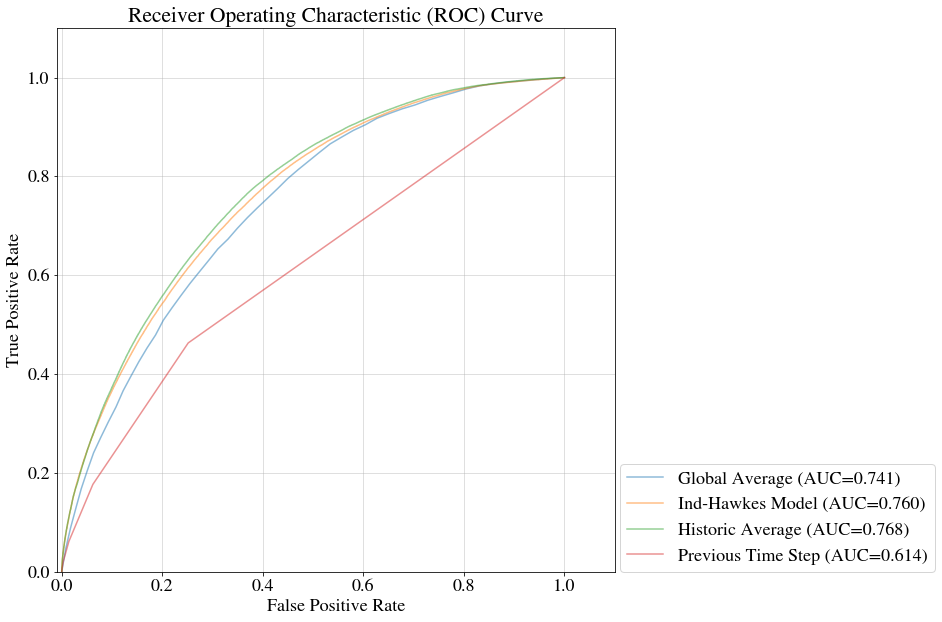

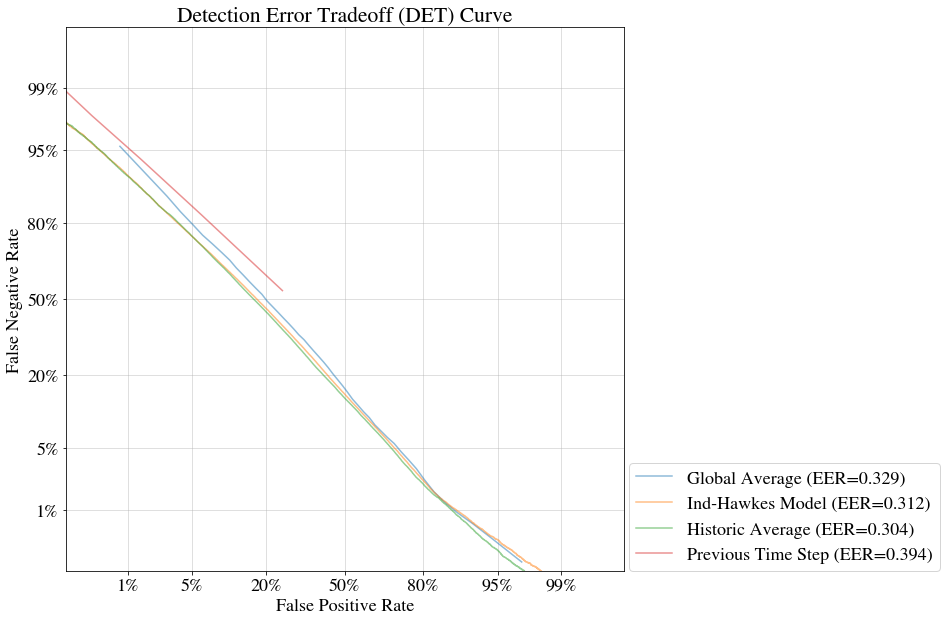

---------------------------------------------------------------------------------------------------- 



In [9]:
# data_path = conf.model_path[:conf.model_path.find("models")]
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"
    print(data_sub_path)
    compare_all_models(data_path)
    print(100*'-','\n')

____

In [8]:
# from utils.interactive import plot_interactive_roc, plot_interactive_pr, plot_interactive_det
# plot_interactive_roc(conf.data_path).show()
# plot_interactive_pr(conf.data_path,beta=1).show()
# # plot_interactive_det(conf.data_path).show()

--------

In [26]:
from IPython.display import display

In [27]:
display(metrics)

,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.744610,0.594146,0.767960,0.599773,0.492021,0.767551,0.599650,0.672902,0.369272,1.637903,0.875495,0.464481
Global Average,0.744180,0.593606,0.741029,0.543517,0.442192,0.831312,0.577304,0.611478,0.323271,1.444136,0.881671,0.469950
Ind-Hawkes Model,0.740994,0.590804,0.760160,0.593471,0.479496,0.767188,0.590148,0.659907,0.351375,1.594083,0.852926,0.470643
Previous Time Step,0.649550,0.417291,0.614368,0.413630,0.319153,1.000000,0.483875,0.319153,0.000000,1.000000,0.878663,0.462621


'./data/processed/T1H-X3400M-Y3520M_2014-01-01_2017-01-01_#7cd/'

In [41]:
for data_sub_path in data_sub_paths:
    models_metrics = get_models_metrics(data_path=f'./data/processed/{data_sub_path}/')
    display(HTML(f'<br><h3>{data_sub_path}</h3>'))
    metrics = get_metrics_table(models_metrics)
    display(metrics)

,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.770923,0.519050,0.811395,0.498601,0.423231,0.608238,0.499143,0.795671,0.385698,2.804940,0.654759,0.238585
Global Average,0.770235,0.517482,0.810393,0.493777,0.433649,0.580852,0.496571,0.802853,0.383418,2.897413,0.655142,0.238543
Ind-Hawkes Model,0.770105,0.516329,0.809572,0.498062,0.435428,0.578166,0.496746,0.803902,0.383816,2.928152,0.601779,0.261904
Previous Time Step,0.650002,0.282538,0.624644,0.270566,0.368044,0.368181,0.368113,0.788413,0.241045,2.569801,0.649877,0.238042


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.955609,0.989883,0.892652,0.989151,0.943901,0.999520,0.970915,0.944733,0.516437,1.023163,6.263646,4.603981
Global Average,0.955217,0.989831,0.892805,0.988594,0.943901,0.999520,0.970915,0.944733,0.516437,1.023163,6.263801,4.603416
Previous Time Step,0.924389,0.977829,0.824806,0.977959,0.922892,1.000000,0.959900,0.922892,0.000000,1.000000,6.256132,4.603594
Ind-Hawkes Model,0.869585,0.988537,0.882543,0.987881,0.945300,0.998148,0.971005,0.944986,0.519141,1.025730,5.862637,4.081975


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.675668,0.452320,0.765756,0.450654,0.383750,0.654098,0.483713,0.715717,0.326155,2.010857,0.604195,0.273351
Global Average,0.673363,0.450470,0.743988,0.399999,0.353731,0.659012,0.460359,0.685439,0.291462,1.844392,0.607679,0.276165
Ind-Hawkes Model,0.673008,0.449022,0.757852,0.442457,0.373592,0.649360,0.474305,0.706934,0.312433,1.958410,0.593107,0.281561
Previous Time Step,0.576200,0.270951,0.586590,0.261741,0.336673,0.336642,0.336658,0.729902,0.167085,1.790478,0.608262,0.272325


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.899369,0.845069,0.795136,0.841644,0.716020,0.887351,0.792532,0.725870,0.422461,1.279871,2.099060,1.246949
Global Average,0.898478,0.844222,0.794518,0.839837,0.687087,0.931549,0.790857,0.709279,0.394562,1.202691,2.098983,1.246869
Ind-Hawkes Model,0.890832,0.841123,0.791577,0.838329,0.697968,0.914053,0.791528,0.715895,0.404575,1.232031,1.854985,1.097124
Previous Time Step,0.850204,0.734896,0.683800,0.734490,0.590059,1.000000,0.742185,0.590059,0.000000,1.000000,2.096917,1.244226


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.820942,0.522364,0.758734,0.516528,0.426902,0.642980,0.513121,0.704581,0.326823,1.940859,0.792267,0.352349
Global Average,0.819023,0.519837,0.757551,0.513217,0.404315,0.694688,0.511141,0.678284,0.319587,1.806710,0.792356,0.352560
Ind-Hawkes Model,0.812544,0.515363,0.755845,0.510343,0.399889,0.700375,0.509100,0.672990,0.316044,1.779956,0.715724,0.391117
Previous Time Step,0.730862,0.334770,0.605710,0.332304,0.242108,1.000000,0.389834,0.242108,0.000000,1.000000,0.791561,0.348306


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.979311,0.996138,0.965323,0.996012,0.949124,0.988546,0.968434,0.941983,0.632281,1.065182,16.048801,10.484633
Global Average,0.978799,0.996127,0.965351,0.995948,0.941612,0.992574,0.966422,0.937904,0.595064,1.052935,16.047674,10.483032
Previous Time Step,0.976513,0.990231,0.935421,0.990174,0.956276,0.956576,0.956426,0.921530,0.562401,1.102260,16.083819,10.536962
Ind-Hawkes Model,0.754574,0.995210,0.961850,0.995102,0.940241,0.993140,0.965967,0.936997,0.587101,1.050841,15.766353,10.045884


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.926832,0.895040,0.849905,0.893728,0.763371,0.916357,0.832897,0.775190,0.517808,1.308086,2.509605,1.474547
Global Average,0.926412,0.894698,0.849687,0.893016,0.762350,0.917247,0.832656,0.774581,0.516574,1.304972,2.508974,1.474028
Ind-Hawkes Model,0.903300,0.892226,0.847450,0.891203,0.759056,0.919604,0.831652,0.772372,0.511999,1.297588,2.241650,1.273637
Previous Time Step,0.883596,0.793694,0.741649,0.794297,0.760071,0.759793,0.759932,0.706496,0.382394,1.376647,2.514492,1.477376


,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.744610,0.594146,0.767960,0.599773,0.492021,0.767551,0.599650,0.672902,0.369272,1.637903,0.875495,0.464481
Global Average,0.744180,0.593606,0.741029,0.543517,0.442192,0.831312,0.577304,0.611478,0.323271,1.444136,0.881671,0.469950
Ind-Hawkes Model,0.740994,0.590804,0.760160,0.593471,0.479496,0.767188,0.590148,0.659907,0.351375,1.594083,0.852926,0.470643
Previous Time Step,0.649550,0.417291,0.614368,0.413630,0.319153,1.000000,0.483875,0.319153,0.000000,1.000000,0.878663,0.462621



## [Hawkes Model](https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html)
does support multi variate but we are only using univariate for now
### Data Analysis Hawks-proces using the EM kernel